In [99]:
def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]

def subsample_features(df):
    features = []
    for f in df.columns.tolist():
        if 'e0' in f or 'e2' in f:
            continue
        features.append(f)
    df.drop(features, axis=1, inplace=True)
    return df

In [105]:
df = pd.read_csv('results/feature_vector.csv', index_col=0)
df = df[df['group'] == 'none_hearing']

label_names = ['angry','fear','happy', 'neutral', 'sad']
df = subsample_labels(df, label_names)

labels = df['label']
group = df['group']
df.drop(['label', 'group'], axis=1, inplace=True)

df = subsample_features(df)

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
clf = DecisionTreeClassifier(random_state=0, criterion='entropy')
cv_scores = cross_val_score(clf, df, labels, cv=10)
print(cv_scores)
print(np.mean(cv_scores))

[0.6 0.8 0.2 0.8 0.8 0.4 0.8 0.8 0.4 0.4]
0.6000000000000001


[Text(0.6, 0.9166666666666666, 'AU06_e2_intensity <= 0.395\nentropy = 2.322\nsamples = 50\nvalue = [10, 10, 10, 10, 10]\nclass = angry'),
 Text(0.3333333333333333, 0.75, 'AU07_e2_length <= 10.25\nentropy = 1.826\nsamples = 31\nvalue = [2, 10, 0, 9, 10]\nclass = fear'),
 Text(0.13333333333333333, 0.5833333333333334, 'AU04_e2_length <= 5.75\nentropy = 0.817\nsamples = 12\nvalue = [1, 10, 0, 0, 1]\nclass = fear'),
 Text(0.06666666666666667, 0.4166666666666667, 'entropy = 0.0\nsamples = 10\nvalue = [0, 10, 0, 0, 0]\nclass = fear'),
 Text(0.2, 0.4166666666666667, 'AU04_e0_amount <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 0, 0, 0, 1]\nclass = angry'),
 Text(0.13333333333333333, 0.25, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 1]\nclass = sad'),
 Text(0.26666666666666666, 0.25, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0, 0]\nclass = angry'),
 Text(0.5333333333333333, 0.5833333333333334, 'AU12_e0_intensity <= 0.417\nentropy = 1.245\nsamples = 19\nvalue = [1, 0, 0, 9, 9]\nclas

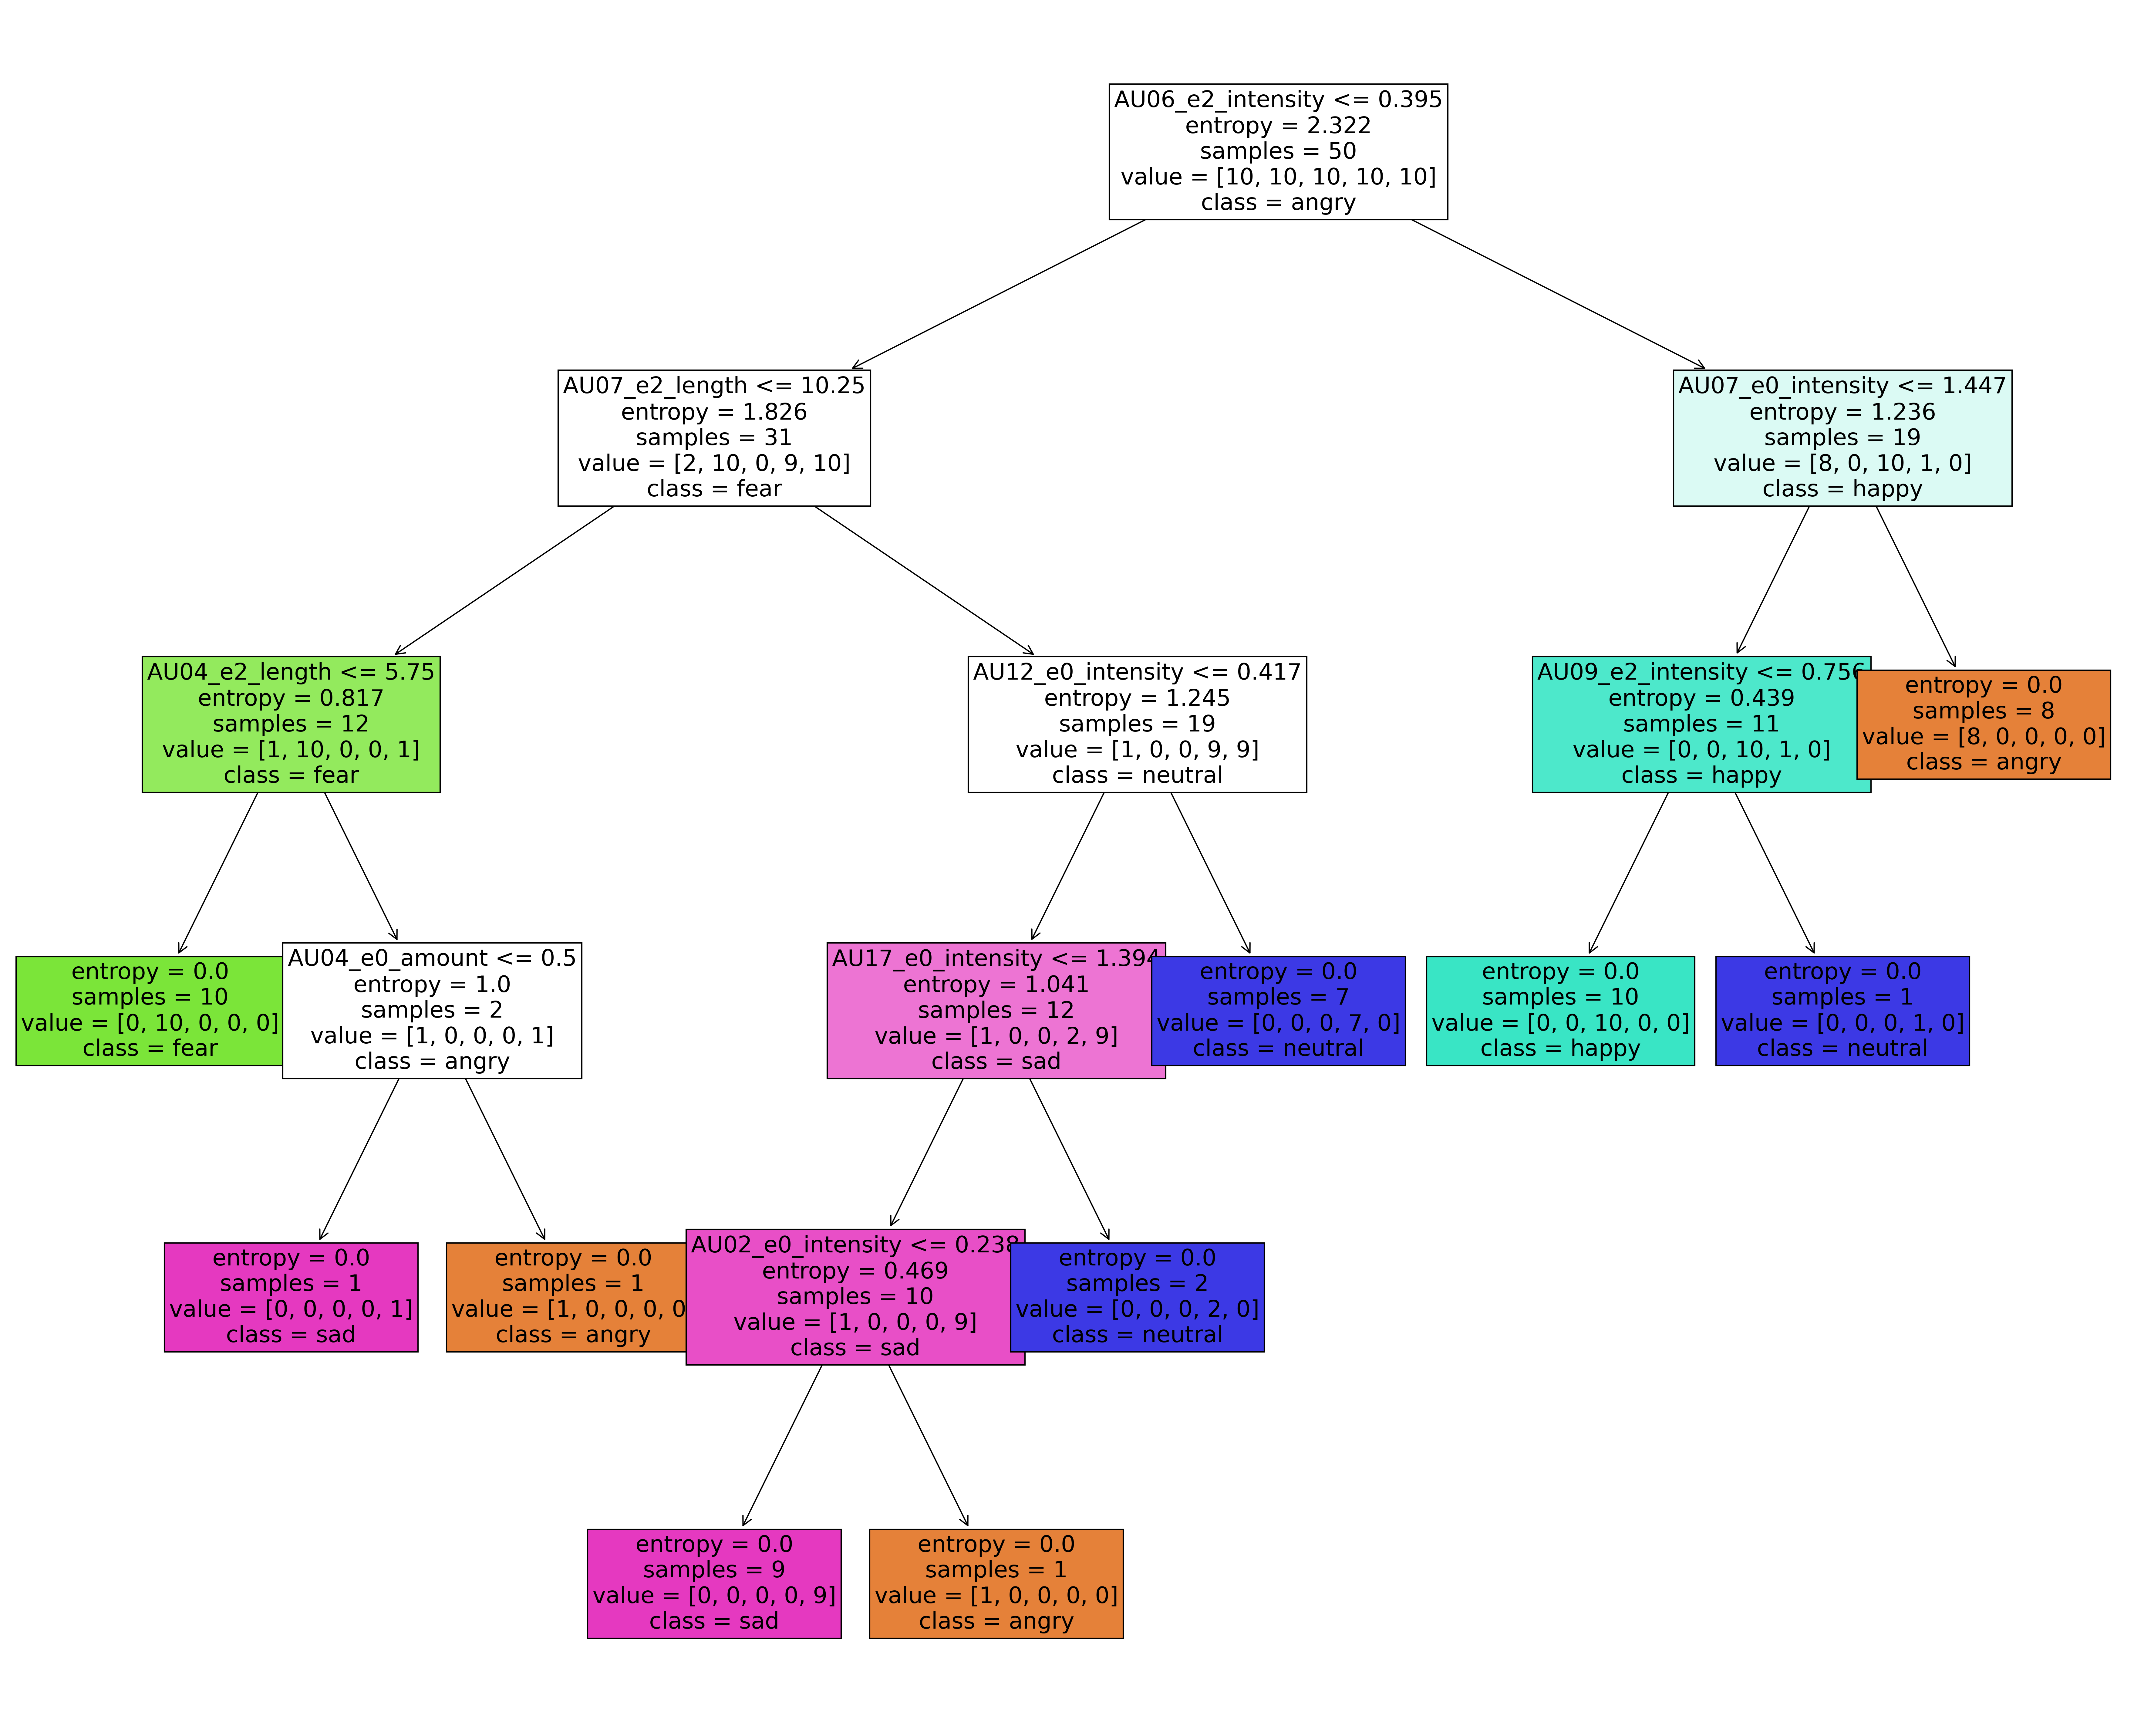

In [108]:
import matplotlib.pyplot as plt
from sklearn import tree
clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')
